
Top 5 likely light curve:

1. Archivo: lc_lat10_lon0_rad15.5.csv, Lat: 10.0, Lon: 0.0, Rad: 15.5, MSE: 0.0001713687
2. Archivo: lc_lat-10_lon0_rad15.5.csv, Lat: -10.0, Lon: 0.0, Rad: 15.5, MSE: 0.0001788327
3. Archivo: lc_lat30_lon0_rad15.5.csv, Lat: 30.0, Lon: 0.0, Rad: 15.5, MSE: 0.0003790279
4. Archivo: lc_lat-30_lon0_rad20.5.csv, Lat: -30.0, Lon: 0.0, Rad: 20.5, MSE: 0.0003897137
5. Archivo: lc_lat-30_lon0_rad15.5.csv, Lat: -30.0, Lon: 0.0, Rad: 15.5, MSE: 0.0003911289


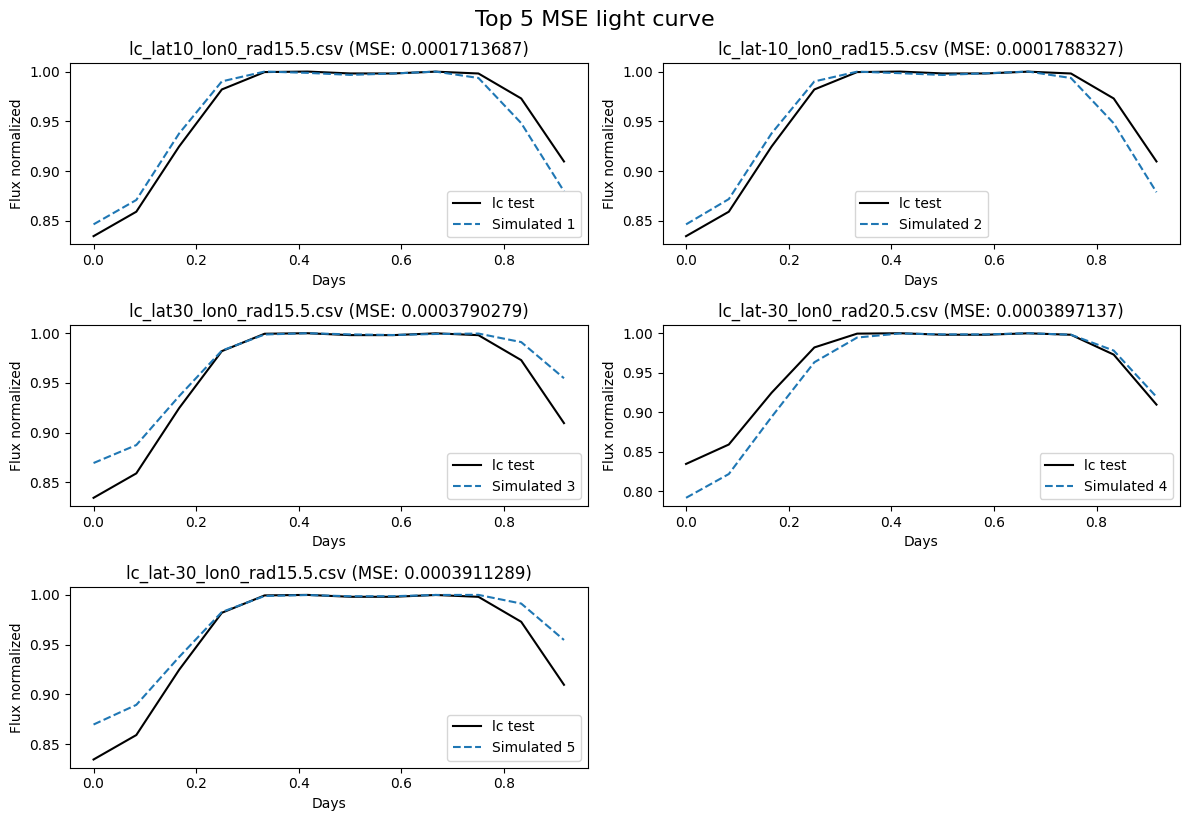

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
import os
from PIL import Image
import glob
import subprocess
import matplotlib as mpl
import gc
import matplotlib
#import seaborn as sns
from sklearn.metrics import mean_squared_error
import emcee
import corner


os.makedirs("frames", exist_ok=True)

# ---- fibonacci sphere ----
def fibonacci_sphere(n_points):
    """generating equal points to distributing in sphere"""
    indices = np.arange(n_points, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n_points)  # [0, π]
    theta = np.pi * (1 + 5**0.5) * indices  # aureo angle
    
    return phi, theta % (2*np.pi)  # etting values between 0 and 2π

def cartesian_from_spherical(phi, theta, r=1.0):
    """Convert spherical coordinates to cartesians"""
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return x, y, z

def spot_mask_geodesic(x, y, z, spot_center, spot_radius_rad):
    """Máscara usando distancia geodésica real con optimización"""
    # Convert the spot_center vector to a unit vector (of length 1).
    center_norm = spot_center / np.linalg.norm(spot_center)
    
    # Product
    positions = np.stack([x, y, z], axis=-1)
    norms = np.linalg.norm(positions, axis=-1, keepdims=True)
    pos_norm = positions / np.clip(norms, 1e-10, None)     
    dot_product = np.sum(pos_norm * center_norm, axis=-1) 
    dot_product = np.clip(dot_product, -1, 1) 
    
    # central_angle is the geodesic distance (in radians) betwe.
    central_angle = np.arccos(dot_product)
    
    return np.exp(-(central_angle**2) / (2 * spot_radius_rad**2))

#function to calculate angular velocity  
def spot_theta(rotation_period, spot_colatitude, relative_shear):
    ''' Parameters:
    - rotation_period: rotation period of the sta
    - spot_colatitude: latitud of spot(radians)
    - relative_shear: parameter between pole and equator
    Returns:
    - angular velocity. '''
    
    latitude = np.pi / 2 - spot_colatitude
    angular_vel_equa = 2*np.pi*u.rad/rotation_period
    angular_velocity = angular_vel_equa*(1-relative_shear*np.sin(latitude)**2)
    return angular_velocity

def limbdarkening(u, mu):
    ''' lineal limb darkening'''
    return (1 - u * (1 - mu))

def quadratic(u1, u2, mu):
    return 1-u1*(1-mu)-u2*(1-mu)**2
    

def add_spots(latitude_deg, longitude_deg, radii_deg):
    colatitude_rad = np.deg2rad(90 - latitude_deg)
    longitude_rad = np.deg2rad(longitude_deg)
    radii_rad = np.deg2rad(radii_deg)
    ang_vel = spot_theta(rotation_period, colatitude_rad, 0.4)  
    spots.append({
        'theta': longitude_rad * u.rad,
        'phi': colatitude_rad,
        'radius': radii_rad,
        'angular_velocity': ang_vel
    })
    #return spots
def gif(input_pattern="frames/frame_%05d.png", output_gif="output.gif", 
        palette="palette.png", framerate=17):
    palette_cmd = [
        "ffmpeg", "-y", "-i", input_pattern,
        "-vf", "palettegen", palette
    ]
    gif_cmd = [
        "ffmpeg", "-y", "-framerate", str(framerate),
        "-i", input_pattern, "-i", palette,
        "-lavfi", "paletteuse", output_gif
    ]
    try:
        subprocess.run(palette_cmd, check=True)
        subprocess.run(gif_cmd, check=True)
        print(f"GIF creado: {output_gif}")
    except subprocess.CalledProcessError as e:
        print("Error en ffmpeg:", e)

def flux_plot(theta_vec):
    '''
    Function take a list normalizing the flux, converting the list in a 
csv file and rename the columns
    and return a plot 

    '''
    #lat,lon,radii = theta_vec
    lat, lon, radii = theta_vec
    frame_files = sorted(glob.glob("frames/frame_*.png"))
    fluxes = []

    for filename in frame_files:
        img = Image.open(filename).convert('L')  # Grayscale
        img_array = np.array(img, dtype=np.float64)
        flux_total = np.sum(img_array)
        fluxes.append(flux_total)

    # Normalized fluxes
    #flux_norm.append(flux_total / fluxes[i])
    flux_norm = normalize([fluxes], norm="max")[0]
    #flux_norm = np.array(fluxes)/np.max(np.array(fluxes))
    df = pd.DataFrame(flux_norm)

    # Creating columns
    df.index.name = 'Frame'
    df.reset_index(inplace=True)
    #changing frames for days
    df['Days'] = df['Frame'] *(cadence_time.to(u.day)).value
    df = df.rename(columns={0: 'flux_normalized'})
    df = df[['Days', 'flux_normalized']]  

    # saving csv
    df.to_csv(f'lat_{lat}_lon_{lon}_radii{radii}.csv', index=False)
 
    
    #df.to_csv("test.csv", index=False)
    # plotting
    
    #ax = df.plot(x="Days", y="flux_normalized", alpha=0.5, linestyle='--', color ="k")
    #ax.set_xlabel("Time [days]")
    #ax.set_ylabel("Normalized Flux")
    #ax.set_title("Lightcurve from PNG frames")
    #plt.style.use('default')
    #plt.tight_layout()
    #plt.savefig(f'lat_{lat}_lon{lon}_radii{radii}.png', dpi=600)
    #plt.show()
    return df["flux_normalized"], df["Days"]

# ---- Función de animación corregida ----
def animate(i, points, base_intensity, ax_sphere, elev, azim, 
total_frames, vmin, vmax):
    ax_sphere.clear()
    ax_sphere.set_axis_off()
    ax_sphere.view_init(elev=elev, azim=azim)
    
    # copying the texture

    intensity = np.copy(base_intensity)
    
    # adding several spots
    for spot in spots:
        # Calcular nueva posición de la mancha
        theta_mov = spot['theta'] + spot['angular_velocity'] * i * cadence_time.to(u.day)
        
        # Calculating position of the spot
        spot_x = r_val * np.sin(spot['phi']) * np.cos(theta_mov.value)
        spot_y = r_val * np.sin(spot['phi']) * np.sin(theta_mov.value)
        spot_z = r_val * np.cos(spot['phi'])
        spot_center = np.array([spot_x, spot_y, spot_z])
        
        # creating a mask
        mask = spot_mask_geodesic(points[:, 0], points[:, 1], points[:, 2], spot_center, spot['radius'])
        intensity *= (1 -  mask)  # Reducción de intensidad en manchas
    
    # scatter plot 
    sc = ax_sphere.scatter(
        points[:, 0], points[:, 1], points[:, 2], 
        #c=intensity,
        c=np.clip(intensity, 0, 1),
        cmap='gray', 
        s=1, 
        alpha=1,
        vmin=0,  # Mínimo fijo
        vmax=1.0   # Máximo fijo
    )
    
    # Configurar límites de la esfera
    max_range = r_val * 1.1
    ax_sphere.set_xlim(-max_range, max_range)
    ax_sphere.set_ylim(-max_range, max_range)
    ax_sphere.set_zlim(-max_range, max_range)
    
    print(f"Procesando frame {i+1}/{total_frames}", end='\r')
    plt.savefig(f"frames/frame_{i:05d}.png", dpi=300, bbox_inches='tight')
    
    return None
 # Generating animation
def star_animate(theta_vec):
    
    #lat,lon,radii = theta_vec
    lat,lon,radii = theta_vec
    add_spots(lat, lon, radii)
        # spherical grid with fibonacci points
    print("Generate spherical grid")
    phi, theta = fibonacci_sphere(n_points)
    x, y, z = cartesian_from_spherical(phi, theta)
    points = np.vstack([x, y, z]).T
    
    # Calculate point of view
    elev_rad = np.deg2rad(elev) #elevation of point of view
    azim_rad = np.deg2rad(azim)#azimut of point of view
    
    v_x = np.cos(elev_rad) * np.cos(azim_rad)
    v_y = np.cos(elev_rad) * np.sin(azim_rad)
    v_z = np.sin(elev_rad)
    
    # rearrange of calculating mu parameter for limb darkening
    mu = (points[:, 0] * v_x + points[:, 1] * v_y + points[:, 2] * v_z) / r_val
    mu = np.clip(mu, 0, 1)
    #base_intensity = limbdarkening(constant, mu)# applying to the texture
    base_intensity = quadratic(u1,u2,mu) 
        #    Calculates the extreme values of the base intensity: 
    #vmin: Minimum value of intensity in the whole star.
    #vmax: Maximum value of intensity over the whole star.
    vmin=  0.0
    vmax=  1.0

   # Defines a reference range for color mapping that will be used consistently across all frames.
 
    
    # background configurations
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(10, 8))
    ax_sphere = fig.add_subplot(111, projection='3d') 
    ax_sphere.set_axis_off()
    ax_sphere.set_box_aspect([1, 1, 1])
    
    #Límits
    max_range = r_val * 1.1
    ax_sphere.set_xlim(-max_range, max_range)
    ax_sphere.set_ylim(-max_range, max_range)
    ax_sphere.set_zlim(-max_range, max_range)

    print("start render...")
    for i in range(total_frames):
        animate(i, points, base_intensity, ax_sphere,  elev, azim, total_frames, vmin, vmax)
    # Create gif an light curve
    #print("\nCreando GIF...")
    #gif(input_pattern="frames/frame_%05d.png", output_gif=f"period_{rotation_period}_points{n_points}_obs{observing_baseline_days}_cadence{cadence_time}_nspots{len(spots)}.gif", framerate=15)
    print("Generating ligthcurve..")
    #to verify if is mcmc is working 
    #print(theta_vec)
    plt.style.use('default')
    spots.clear()
    plt.close(fig) 
    return flux_plot(theta_vec)

def load_tess():
# load tess light_curves
    csv1 = "test.csv"
    #csv2 = f"lat_{float(vec[0])}_lon{float(vec[1])}_radii{float(vec[2])}.csv"
    
    df1 = pd.read_csv(csv1)
    #df2 = pd.read_csv(csv2)
    F = df1["flux_normalized"]
    days =df1["Days"]
    return F, days 

#  verification function to find the aprox parameters value, recibing the test light curve and days
def function_mse(flux, days):
    #simulated folder
    sim_folder = 'light_curve'
    results = []
    #search csv, calculate MSE 
    for file in os.listdir(sim_folder):
        if file.endswith('.csv'):
            path = os.path.join(sim_folder, file)
            try:
                sim_curve = pd.read_csv(path)
                sim_flux = sim_curve['flux_normalized'].values
                sim_time = sim_curve['Days'].values
    
                # if both lenth are equal
                if len(sim_flux) != len(flux):
                    print("❌ light curves are differents.")
                    
                else:
            
        
                    # MSE mean square error
                    mse = np.mean((flux-sim_flux)**2)
        
                    # Extract parameters
                    name_parts = file.replace('.csv', '').split('_')
                    lat = float(name_parts[1].replace('lat', '').replace('-', '-'))
                    lon = float(name_parts[2].replace('lon', ''))
                    rad = float(name_parts[3].replace('rad', ''))
        
                    results.append({
                        'file': file,
                        'lat': lat,
                        'lon': lon,
                        'rad': rad,
                        'mse': mse,
                        'flux': sim_flux
                    })
        
            except Exception as e:
                print(f"Error reading {file}: {e}")
    
    # sorting top 5
    top5 = sorted(results, key=lambda x: x['mse'])[:5]
    
    print("\nTop 5 likely light curve:\n")
    for i, r in enumerate(top5, 1):
        print(f"{i}. Archivo: {r['file']}, Lat: {r['lat']}, Lon: {r['lon']}, Rad: {r['rad']}, MSE: {r['mse']:.10f}")
    
    # plotting LC
    plt.figure(figsize=(12, 8))
    for i, r in enumerate(top5, 1):
        plt.subplot(3, 2, i)
        plt.plot(days, flux, label='lc test', color='black')
        plt.plot(days, r['flux'], label=f"Simulated {i}", linestyle='--')
        plt.title(f"{r['file']} (MSE: {r['mse']:.10f})")
        plt.xlabel("Days")
        plt.ylabel("Flux normalized")
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle("Top 5 MSE light curve", fontsize=16, y=1.02)
    plt.show()

    #return values to be saved in a vector
    return top5[0]["lat"], top5[0]["lon"], top5[0]["rad"]
    



# ---- main ----
if __name__ == '__main__':
    # stellar parameter
    r_val = 1.0
    n_points = 60000
    u1 = 0.4
    u2 =0.3# limb darkening coefficients
    rotation_period = 1.0 * u.day
    
    # Point of view
    elev = 0
    azim = 0
    
    # List of spots
    spots = []
  
    
    # base lines time parameter
    observing_baseline_days = 1 * u.day
    cadence_time = 120 * u.minute
    total_frames = int((observing_baseline_days / cadence_time).decompose().value)
    
    #load flux and days of test light curve
    flux_test, days_test =load_tess()
    #parameters where we are selecting the top1 simulated lightcurve by MSE
    initial_params = function_mse(flux_test, days_test)

    





In [2]:
def inlike(theta_vec,F,days):
    #csv1 = f"{lc1}.csv"
    #csv2 = f"{lc2}.csv"
    
    #df1 = pd.read_csv(csv1)
    #df2 = pd.read_csv(csv2)
    flux_simulated,days_simulated = star_animate(theta_vec)
    #mse = np.mean((df1["flux_normalized"]-df2["flux_normalized"])**2)
    mse = mean_squared_error(F, flux_simulated)
    print(f"📉 MSE entre las curvas: {mse:.15e}")
    #sns.set_theme(style="darkgrid")
# Crear la figura
    #plt.figure(figsize=(10, 6))
    
    # Graficar ambas series
    #sns.lineplot(x=df1["Days"], y=df1["flux_normalized"], label="Test")
    #sns.lineplot(x=df2["Days"], y=df2["flux_normalized"], label="Simulated")
    #sns.lineplot(x=days, y=F, label="Test")
    #sns.lineplot(x=days_simulated, y=flux_simulated, label="Simulated")
    
    # Personalizar
    #plt.title("Light-curve Comparison")
    #plt.xlabel("Days")
    #plt.ylabel("Flux Normalized")
    #plt.ylim(0,1.1)
    #plt.legend()
    
    # Mostrar gráfico
    #plt.show()
    return -mse


In [3]:
def lnprior(theta_vec):
    #radii = theta_vec
    lat, lon, radii = theta_vec
    if -90.0 <= lat <= 90.0 and 0.1 <= radii <= 50.0:
        return 0.0
    return -np.inf



In [4]:
#def lnprob(theta_vec, F, days):
#    lp = lnprior(theta_vec)
#    if not np.isfinite(lp):
#        return -np.inf
#    return lp + lnlike(theta_vec, F,days)
def lnprob(theta_vec, data):
    days, F, Ferr = data
    lp = lnprior(theta_vec)
    if not np.isfinite(lp):
        return -np.inf
    return lp + inlike(theta_vec, F, days)




In [5]:
flux_err = 0.00005*np.mean(flux_test)
data = (days_test,flux_test,flux_err)
nwalkers = 10
niter = 10
initial = np.array(initial_params)

#ndim = len(initial)
ndim = len(initial)
#p0 = np.array([initial + 2*np.random.randn(ndim) for i in range(nwalkers)])[:, None]
p0 = [np.array(initial) + 1 * np.random.randn(ndim) for i in range(nwalkers)]





In [6]:

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data,))

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 2)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state



In [ ]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)



Running burn-in...
Generate spherical grid
start render...
Generating ligthcurve..
📉 MSE entre las curvas: 2.245602836900461e-04
Generate spherical grid
start render...
Procesando frame 6/12

In [ ]:

# Obtener los mejores parámetros
samples = sampler.flatchain
best_params = samples[np.argmax(sampler.flatlnprobability)]

labels = ['lat', 'lon','radii']

# Crear una sola figura con los valores verdaderos
fig = corner.corner(samples, 
                   show_titles=True, 
                   labels=labels, 
                   plot_datapoints=True, 
                   quantiles=[0.16, 0.5, 0.84],
                   truths=best_params,
                   truth_color='red')  # Puedes personalizar el color

# Agregar texto con los valores en una posición que no se superponga
# Usamos transform=fig.transFigure para coordenadas relativas a la figura completa
fig.text(0.75, 0.75, f'Best params: {np.round(best_params, 2)}', 
         fontsize=10, 
         bbox=dict(facecolor='white', alpha=0.8),
         transform=fig.transFigure,  # Importante: usa coordenadas de figura
         ha='center')  # Alineación horizontal centrada

# Ajustar diseño para evitar superposiciones
plt.tight_layout()

# Guardar la figura
fig.savefig('corner_plot_with_truths.png', dpi=300, bbox_inches='tight')
plt.close(fig)